In [1]:
import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('/mnt/d/housekeeping_genes')
import housekeepingMinerPy as hkg

In [3]:
adata = ad.read_h5ad('/mnt/d/postransplant_cristian_colab/predictor/adata_ALLgenes_ngs_ma_predictor_dataset.h5ad')
adata

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2'
    layers: 'arcsinh'

In [4]:
hkg.pp.log_transform(adata, method='log1p')
hkg.pp.log_transform(adata, method='arcsinh')

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2'
    layers: 'arcsinh', 'log1p'

In [5]:
# adata.obs['type'] = adata.obs.gse.map({'GSE175718':'TMM', 'GSE120649':'TMM', 'GSE14346':'quantile', 'GSE15296':'quantile', 'GSE129166':'quantile', 'GSE46474':'quantile'})
adata.obs['type'] = adata.obs.gse.map({'GSE175718':'TMM4', 'GSE120649':'TMM4', 'GSE14346':'quantile', 'GSE15296':'quantile', 'GSE129166':'quantile', 'GSE46474':'quantile'})

adata

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    layers: 'arcsinh', 'log1p'

In [6]:
trns_dict = dict(adata.obs[['louvain_group','type']].values)
print(trns_dict)
hkg.pp.transform_exprs(adata, groups_col='louvain_group', trns_dict=trns_dict)

{8: 'TMM4', 2: 'TMM4', 7: 'TMM4', 3: 'TMM4', 5: 'TMM4', 9: 'TMM4', 6: 'TMM4', 4: 'TMM4', 1: 'TMM4', 0: 'TMM4', 19: 'quantile', 20: 'quantile', 21: 'quantile', 22: 'quantile', 23: 'quantile', 24: 'quantile', 10: 'quantile', 14: 'quantile', 17: 'quantile', 13: 'quantile', 11: 'quantile', 15: 'quantile', 16: 'quantile', 12: 'quantile', 18: 'quantile', 26: 'quantile', 25: 'quantile'}


/mnt/d/housekeeping_genes/housekeepingMinerPy/pp.py:253: UserWarning: The trns_dict value for the group8 is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['8 = TMM4
  warnings.warn("The trns_dict value for the group" + str(gc) + " is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['"+str(gc)+" = "+str(trns_dict[gc]))
/mnt/d/housekeeping_genes/housekeepingMinerPy/pp.py:253: UserWarning: The trns_dict value for the group2 is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['2 = TMM4
  warnings.warn("The trns_dict value for the group" + str(gc) + " is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['"+str(gc)+" = "+str(trns_dict[gc]))
/mnt/d/housekeeping_genes/housekeepingMinerPy/pp.py:253: UserWarning: The trns_dict 

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    layers: 'arcsinh', 'log1p', 'trns_expr'

# Exclude genes with high number of zeros expressions

In [7]:
aux = adata.to_df()

<Axes: ylabel='Count'>

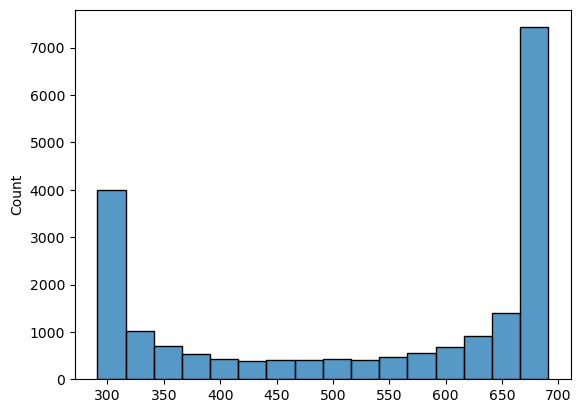

In [8]:
sns.histplot(data=(aux>0).sum())

In [9]:
th = (aux>0).sum().quantile(.7)
print(th)
# cols = aux.loc[:,(((aux>0).sum())>=th).values].columns
cols = aux.loc[:,(((aux>0).sum())>=th).values].columns
aux.loc[:,(((aux>0).sum())>=th).values].head()

679.0


,NMNAT3,NMT1,LPCAT1,KRT23,EVL,MACF1,PRPF19,NEK7,APOL1,PHKG2,...,CCT5,PURA,HLA-DRB1,NLRC5,SERINC3,PHACTR1,SLC7A14,CTDSP2,NCOA2,PDE4B
SRR14675811,3.698268,17.869562,1.247063,3.279311,13.157526,9.208133,1.969213,1.385902,3.378063,0.800857,...,5.351533,8.111878,35.055475,9.766339,4.818316,1.233866,0.574693,3.515069,3.136384,9.050980
SRR14675812,1.216780,4.714020,0.113627,0.741127,3.365281,9.412744,0.050293,0.565136,1.491737,0.204446,...,0.517397,2.926578,4.955858,2.845137,1.313767,1.675404,0.276092,1.226684,0.853023,2.809990
SRR14675813,8.288824,33.533007,0.787019,3.762472,23.296083,8.160651,1.672085,1.956752,5.025311,2.414696,...,6.689530,9.742505,93.873232,20.077701,6.593228,1.376828,0.752742,7.310164,2.464601,32.181997
SRR14675814,3.256562,16.929764,1.062071,4.919020,14.073394,7.278472,1.631437,0.640845,4.142695,1.145673,...,5.449680,9.510379,45.416548,9.583654,3.362681,3.833964,0.252629,3.344405,0.898820,6.214739
SRR14675815,2.328703,17.900022,1.724819,1.685062,11.383978,4.592463,0.717625,0.863289,2.081147,0.685227,...,3.552950,5.824697,12.197730,9.291400,3.087440,1.910687,0.174879,2.491886,0.949243,4.179272


In [10]:
adata = adata[:,cols]
adata

View of AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [11]:
hkg.mining.exprs_cv(adata, layer='trns_expr', groups_col='louvain_group')

/mnt/d/housekeeping_genes/housekeepingMinerPy/mining.py:62: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mean_'+str(gc)] = np.mean(X_, axis=0)


AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'pool_mean', 'pool_std', 'pool_cv'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [12]:
hkg.mining.stability_cv(adata, layer='trns_expr', groups_col='louvain_group')

Computing groups data: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [13]:
from sklearn.neighbors import NearestNeighbors
from sknetwork.clustering import Louvain
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [14]:
nearestNeighbors_object = NearestNeighbors()
louvain_object = Louvain(random_state=42, resolution=.5)
scaler_object = StandardScaler()

In [15]:
hkg.mining.uclustering_cv_stb(adata, cv_col='pool_cv', stb_col='pool_stability_cv',
                              nearestNeighbors_object=nearestNeighbors_object,
                              louvain_object=louvain_object,scaler_object=scaler_object)

AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [16]:
adata.var.uclustering_cv_stb_labels.nunique()

36

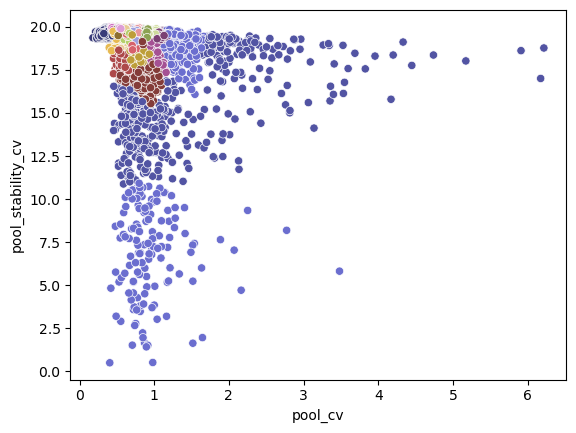

In [17]:
ax = sns.scatterplot(x='pool_cv',y='pool_stability_cv', hue='uclustering_cv_stb_labels', palette='tab20b', data=adata.var, legend=False)

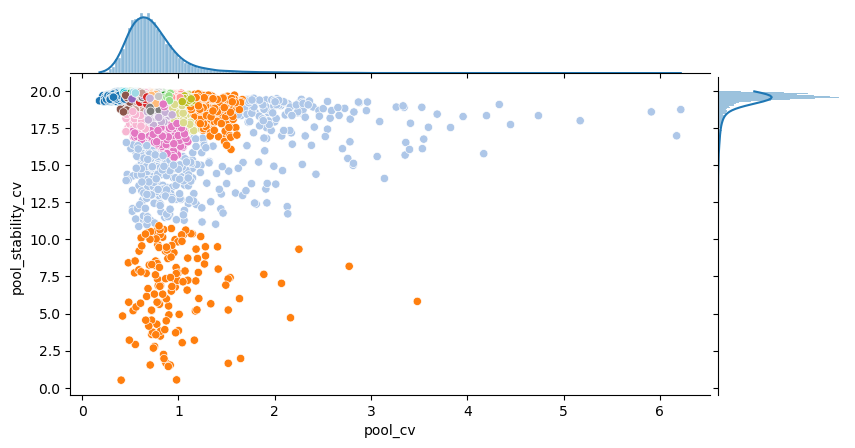

In [20]:
hkg.plot.plot_stb_cv(adata, hue='uclustering_cv_stb_labels', palette='tab20')

In [25]:
import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

def plot_stb_cv(adata, x:str = 'pool_cv', y:str = 'pool_stability_cv', hue:str = 'uclustering_cv_stb_labels'):
    fig = plt.figure(figsize=(8.35,8.35))
    gs = GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], wspace=.02, hspace=.02)

    ax_clu = fig.add_subplot(gs[1,0])
    ax_hist_cv = fig.add_subplot(gs[1,1])
    ax_hist_mean = fig.add_subplot(gs[0,0])

    sns.scatterplot(x=x, y=y, hue=hue, palette=None, data=adata.var, s=60, ax=ax_clu)
    ax_clu.spines[['right', 'top']].set_visible(False)

    sns.histplot(x=x, ec='white', data=adata.var, kde=True, ax=ax_hist_mean)
    ax_hist_mean.spines[['left','right', 'top']].set_visible(False)
    ax_hist_mean.set_xlabel(None)
    ax_hist_mean.set_ylabel(None)
    ax_hist_mean.set_xticklabels([])
    ax_hist_mean.set_yticklabels([])
    ax_hist_mean.tick_params(left = False)
    ax_hist_mean.grid(False)

    sns.histplot(y=y, ec='white', data=adata.var, kde=True, ax=ax_hist_cv)
    ax_hist_cv.spines[['right', 'top','bottom']].set_visible(False)
    ax_hist_cv.set_ylabel(None)
    ax_hist_cv.set_xlabel(None)
    ax_hist_cv.set_yticklabels([])
    ax_hist_cv.set_xticklabels([])
    ax_hist_cv.tick_params(bottom = False)
    ax_hist_cv.grid(False)

    # return fig

TypeError: plot_stb_cv() got an unexpected keyword argument 'palette'

In [27]:
import tempfile
import itertools
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances

In [38]:
adata = adata[:, :5]

In [138]:
cols_ = []
idx_ = []
groups_col = 'louvain_group'
X_ = adata.layers['trns_expr']
df_mean_ = []
df_std_ = []
j = 0
groups = adata.obs[groups_col].unique()
for i,gc in enumerate(groups):
    print(i, end=' ')
    idx = np.where(adata.obs[groups_col]==gc)
    df_mean_.append( pairwise_distances(X_[idx,:][0].T).mean(axis=0) )
    df_std_.append( pairwise_distances(X_[idx,:][0].T).std(axis=0) )
    # .append(mean_X_)
    # .append(std_X_)
# aux = pd.DataFrame(df_std_, columns=cols_, index=groups)/pd.DataFrame(df_mean_, columns=cols_, index=groups)
# del(df_std_)
# del(df_mean_)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [149]:
pairwise_distances(X_[:,:].T).std(axis=0) / pairwise_distances(X_[:,:].T).mean(axis=0)

array([31.80105014, 31.51076177, 31.98414822, ..., 32.01317731,
       32.13324751, 32.09113263])

In [174]:
aux = pd.DataFrame(np.array(df_std_) / np.array(df_mean_)).T
aux.columns = ['gc_'+str(g) for g in groups]
aux

,gc_8,gc_2,gc_7,gc_3,gc_5,gc_9,gc_6,gc_4,gc_1,gc_0,...,gc_14,gc_17,gc_13,gc_11,gc_15,gc_16,gc_12,gc_18,gc_26,gc_25
0,33.712148,37.854610,30.344044,33.927517,34.428704,31.265417,36.846921,32.834539,34.129976,25.735936,...,0.537394,0.566831,0.752540,0.607329,0.549425,0.588862,0.626404,0.614936,0.533541,0.634044
1,33.884421,37.966903,29.862405,33.813666,34.674488,31.211331,37.096299,32.805951,31.659862,20.140710,...,1.077456,1.047807,1.099893,1.103388,1.024392,1.069875,1.083297,1.069468,1.015483,0.993912
2,33.943080,38.098223,30.975092,34.304407,35.003174,31.282843,37.224410,33.802238,33.421917,23.170773,...,0.708590,0.787005,0.569519,0.744603,0.704903,0.628132,0.715949,0.738218,0.623473,0.679039
3,33.536398,37.812253,30.179171,33.489584,34.597237,31.270713,37.001334,33.410994,34.328347,26.230049,...,0.332160,0.376877,0.296770,0.315294,0.300599,0.293204,0.307696,0.352859,0.310655,0.297306
4,33.755481,38.027778,30.711519,34.140146,34.810167,31.167430,37.107628,33.562803,34.470864,26.436957,...,0.881399,0.782858,0.778564,0.884723,0.820884,0.781399,0.817679,0.859213,0.575551,0.626958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,33.851090,38.058819,30.822194,34.314018,34.649977,31.294309,37.162580,33.338767,33.809245,25.146018,...,0.437228,0.549896,0.351828,0.400803,0.423638,0.418765,0.355791,0.465915,0.359092,0.338844
2125,32.573522,37.474768,28.254035,32.617580,33.692795,31.109704,36.106875,31.577571,31.319904,19.632275,...,1.015007,0.961417,1.012342,1.018804,0.978202,0.987881,1.015146,0.981714,1.010361,1.005151
2126,33.865384,38.082253,30.832617,34.297910,34.910746,31.279061,37.189708,33.699908,33.716253,23.820033,...,1.094967,1.042664,1.094336,1.111421,1.050594,1.067086,1.094451,1.046086,1.075890,1.064157
2127,33.888833,38.082066,30.963397,34.233472,34.926460,31.271717,37.235983,33.690716,34.498268,26.484824,...,1.124372,1.074739,1.113702,1.131445,1.089499,1.091813,1.126486,1.091035,1.064130,1.066080


In [166]:
(pd.DataFrame(df_std_) / pd.DataFrame(df_mean_))#.mean(axis=0).sort_values()

,0,1,2,3,4,5,6,7,8,9,...,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128
0,33.712148,33.884421,33.943080,33.536398,33.755481,33.856560,32.912147,33.654800,33.871838,33.805705,...,29.574178,33.757345,33.820386,33.764483,23.989367,33.851090,32.573522,33.865384,33.888833,33.758087
1,37.854610,37.966903,38.098223,37.812253,38.027778,38.075624,37.338808,37.902503,38.077872,38.075637,...,36.500088,38.030298,38.059610,38.048886,34.537898,38.058819,37.474768,38.082253,38.082066,38.047201
2,30.344044,29.862405,30.975092,30.179171,30.711519,30.912682,29.177947,30.258487,30.960445,30.975212,...,24.393286,30.810543,30.817761,30.829915,21.322306,30.822194,28.254035,30.832617,30.963397,30.840261
3,33.927517,33.813666,34.304407,33.489584,34.140146,34.200432,32.895037,33.970324,34.259007,34.270961,...,29.586378,34.128269,34.139334,34.120706,26.378003,34.314018,32.617580,34.297910,34.233472,34.220636
4,34.428704,34.674488,35.003174,34.597237,34.810167,34.906617,33.371481,34.734824,34.937590,34.956476,...,32.330504,34.811497,34.895957,34.863682,30.048254,34.649977,33.692795,34.910746,34.926460,34.713433
5,31.265417,31.211331,31.282843,31.270713,31.167430,31.280226,30.951243,31.276802,31.285305,31.267506,...,31.171255,31.279277,31.292487,31.292291,30.925393,31.294309,31.109704,31.279061,31.271717,31.287808
6,36.846921,37.096299,37.224410,37.001334,37.107628,37.218402,36.706198,36.799265,37.176202,37.193032,...,33.292034,37.132185,37.161763,37.141170,31.365057,37.162580,36.106875,37.189708,37.235983,37.156504
7,32.834539,32.805951,33.802238,33.410994,33.562803,33.694867,31.278340,33.535953,33.750341,33.765025,...,30.339102,33.565650,33.675126,33.646798,27.826684,33.338767,31.577571,33.699908,33.690716,33.720693
8,34.129976,31.659862,33.421917,34.328347,34.470864,34.156661,34.414874,34.336676,34.435473,34.031543,...,33.973682,34.438171,33.711610,34.480771,33.311946,33.809245,31.319904,33.716253,34.498268,34.451313
9,25.735936,20.140710,23.170773,26.230049,26.436957,25.869226,26.324253,25.945176,26.347265,25.586754,...,24.874632,26.435539,24.988275,26.289497,24.654756,25.146018,19.632275,23.820033,26.484824,26.427916


In [58]:
cols_ = []
idx_ = []
groups_col = 'louvain_group'
X_ = adata.layers['trns_expr']
df_mean_ = []
df_std_ = []
j = 0
groups = adata.obs[groups_col].unique()
for k,gc in enumerate(groups):
    print(k, end=' ')
    idx = np.where(adata.obs[groups_col]==gc)
    mean_X_ = []
    std_X_ = []
    for i in range(X_.shape[1]):
        mean_X_.extend(np.mean(X_[idx,i:] - X_[idx,i,None], axis=1)[0].astype(str))
        std_X_.extend(np.std(X_[idx,i:] - X_[idx,i,None], axis=1)[0].astype(str))
        if j == 0:            
            cols_.extend([','.join(p) for p in itertools.product([adata.var.index[i]],adata.var[i:].index)])                
    j+=1

    if k == 0:
        with open('/mnt/d/housekeeping_genes/test_stb_mean.csv', 'w') as f:
            f.write('\t'.join(cols_)+'\n')
    with open('/mnt/d/housekeeping_genes/test_stb_mean.csv', 'a') as f:
        f.write('\t'.join(mean_X_)+'\n')
#     df_mean_.append(mean_X_)
#     df_std_.append(std_X_)
# aux = pd.DataFrame(df_std_, columns=cols_, index=groups)/pd.DataFrame(df_mean_, columns=cols_, index=groups)
# del(df_std_)
# del(df_mean_)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [100]:
X_ = adata.layers['trns_expr']

In [108]:
pairwise_distances(X_.T).mean(axis=0)

array([6079.36114954, 6135.31541746, 6044.7064307 , ..., 6039.21480393,
       6016.74664974, 6024.5745967 ])

In [110]:
pairwise_distances(X_.T).std(axis=0)

array([193330.06873945, 193328.46250872, 193334.78642725, ...,
       193334.45436032, 193337.6092993 , 193335.42242762])

In [98]:
X_[:,0] - X_[:,1]

array([ -1, -11])

In [19]:
aux = pd.DataFrame(df_std_, columns=cols_, index=groups)/pd.DataFrame(df_mean_, columns=cols_, index=groups)
aux = aux[[c for c in aux.columns if (len(set(c.split(',')))>1)]].abs()
aux = aux.mean(axis=0).reset_index()
aux.columns = ['gene', 'stability_cv']
aux[['G1','G2']] = aux['gene'].str.split(',', expand=True)
aux = pd.concat([aux[['G1','stability_cv']].set_index('G1'), aux[['G2','stability_cv']].set_index('G2')], axis=0).reset_index()
aux.columns = ['gene', 'stability_cv']
# adata.var['pool_stability_cv'] = aux.groupby('gene').mean().loc[adata.var.index,:]
aux

,gene,stability_cv
0,TPT1,0.386237
1,TPT1,0.365534
2,TPT1,0.689933
3,TPT1,0.459710
4,TPT1,0.484252
...,...,...
235,TRIM13,0.324191
236,SYNE3,0.231898
237,TRIM13,0.441273
238,SYNE3,0.380119


In [140]:
adata.var

,pool_mean,pool_std,pool_cv,pool_stability_cv
TPT1,99.870647,101.984256,1.021163,1.281687
STIP1,1.542766,0.726204,0.470715,1.118414
SCFD1,4.743274,2.149083,0.453080,2.230019
RPL37,47.793400,45.747994,0.957203,4.606917
OGA,6.913984,4.028201,0.582616,1.373671
SAMHD1,5.647720,3.479893,0.616159,0.836379
SLC25A37,206.447476,186.235511,0.902096,0.714871
RYBP,4.081056,2.947615,0.722268,1.262018
SPECC1,4.439930,3.895261,0.877325,1.179602
EPB41,13.324056,15.192647,1.140242,1.627686


In [103]:
adata[adata.obs.gse=='GSE120649',:].X

ArrayView([[9.98638170e+01, 2.06423100e+00, 3.80511600e+00,
            3.58792590e+01, 1.47395240e+01, 1.29085990e+01,
            3.90202832e+02, 1.43453200e+00, 1.21606710e+01,
            4.95345740e+01, 4.35112400e+00, 1.21213804e+05,
            4.68641160e+01, 1.57683926e+04, 7.74075000e-01,
            1.62781200e+00],
           [2.92362182e+02, 8.01974800e+00, 1.51823210e+01,
            1.11205999e+02, 4.37109740e+01, 4.69621330e+01,
            3.72636744e+02, 4.37952400e+00, 2.06417450e+01,
            6.12572010e+01, 1.51558080e+01, 1.17208240e+05,
            1.15346969e+02, 1.44692470e+04, 3.34425000e+00,
            5.09943500e+00],
           [8.72300815e+02, 7.26774800e+00, 1.84634900e+01,
            4.17397507e+02, 5.62469270e+01, 4.40823270e+01,
            2.58591105e+02, 5.73111700e+00, 1.53003950e+01,
            5.94940740e+01, 2.20880010e+01, 9.18616368e+04,
            1.23745731e+02, 8.47847636e+03, 6.19110400e+00,
            5.22581100e+00],
           [4

In [102]:
adata.obs.gse.unique()

['GSE175718', 'GSE120649', 'GSE14346', 'GSE15296', 'GSE129166', 'GSE46474']
Categories (6, object): ['GSE14346', 'GSE15296', 'GSE46474', 'GSE120649', 'GSE129166', 'GSE175718']

In [90]:
np.mean(X_[idx,i:] - X_[idx,i,None], axis=1).shape

(1, 2129)

In [94]:
np.mean(X_[idx,129:] - X_[idx,129,None], axis=1)[0]

array([ 0.        , -0.09190557, -0.60799553, ...,  0.00485014,
        0.01155771, -0.41119867])

In [96]:
len(mean_X_)

57483

In [1]:
# df_temp = pd.read_csv(temp.name)
# df_temp
temp.close()

NameError: name 'temp' is not defined

In [36]:
df_temp

NameError: name 'df_temp' is not defined

In [20]:
# 